In [266]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d as conv2d
import scipy.sparse as sps
from PIL import Image

# # Package for fast equation solving
from sys import platform
print(platform)
if platform == "linux" or platform == "linux2":
    ! apt-get install libsuitesparse-dev
elif platform == "darwin":
    ! brew install suite-sparse

! pip3 install sparseqr
import sparseqr

linux
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsuitesparse-dev is already the newest version (1:5.1.2-2).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.


In [267]:
! wget http://6.869.csail.mit.edu/fa19/psets19/pset1/img1.png
! wget http://6.869.csail.mit.edu/fa19/psets19/pset1/img2.png
! wget http://6.869.csail.mit.edu/fa19/psets19/pset1/img3.png
! wget http://6.869.csail.mit.edu/fa19/psets19/pset1/img4.png

--2021-03-02 01:49:53--  http://6.869.csail.mit.edu/fa19/psets19/pset1/img1.png
Resolving 6.869.csail.mit.edu (6.869.csail.mit.edu)... 128.30.100.221
Connecting to 6.869.csail.mit.edu (6.869.csail.mit.edu)|128.30.100.221|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96264 (94K) [image/png]
Saving to: ‘img1.png.26’

img1.png.26         100%[===================>]  94.01K  --.-KB/s    in 0.1s    

2021-03-02 01:49:54 (645 KB/s) - ‘img1.png.26’ saved [96264/96264]

--2021-03-02 01:49:54--  http://6.869.csail.mit.edu/fa19/psets19/pset1/img2.png
Resolving 6.869.csail.mit.edu (6.869.csail.mit.edu)... 128.30.100.221
Connecting to 6.869.csail.mit.edu (6.869.csail.mit.edu)|128.30.100.221|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76847 (75K) [image/png]
Saving to: ‘img2.png.26’

img2.png.26         100%[===================>]  75.05K  --.-KB/s    in 0.1s    

2021-03-02 01:49:54 (516 KB/s) - ‘img2.png.26’ saved [76847/76847]

--2021-03-02 0

ground (256, 373) [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


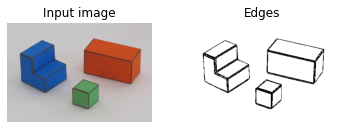

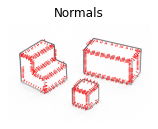

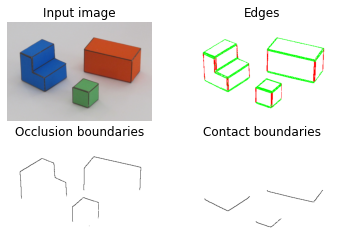

In [268]:
# World parameters
alpha = 35*math.pi/180;

img = cv2.imread('img1.png')
img = img[:, :, ::-1].astype(np.float32)

nrows, ncols, colors = img.shape
ground = (np.min(img, axis=2) > 110).astype(np.float32)
print('ground', ground.shape, ground)
foreground = (ground == 0).astype(np.float32)

m = np.mean(img, 2)
kern = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)
dmdx = conv2d(m, kern, 'same')
dmdy = conv2d(m, kern.transpose(), 'same')

mag = np.sqrt(dmdx**2 + dmdy**2)
mag[0, :] = 0
mag[-1, :] = 0
mag[:, 0] = 0
mag[:, -1] = 0

edges = mag >= 30
edges = edges * foreground

## Occlusion and contact edges
pi = math.pi
theta = np.arctan2(dmdx, dmdy) ###TODO
vertical_edges = edges * ((theta<(90+15)*pi/180)*(theta>(90-15)*pi/180)+(theta<-(90-15)*pi/180)*(theta>-(90+15)*pi/180)) ##TODO
horizontal_edges = edges * (1-vertical_edges) ##TODO #complement of vertical edges

kern = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float32)
horizontal_ground_to_foreground_edges = (conv2d(ground, kern, 'same'))>0;
horizontal_foreground_to_ground_edges = (conv2d(foreground, kern, 'same'))>0;
vertical_ground_to_foreground_edges = vertical_edges*np.abs(conv2d(ground, kern.transpose(), 'same'))>0


occlusion_edges = edges*(vertical_ground_to_foreground_edges + horizontal_ground_to_foreground_edges)
contact_edges   = horizontal_edges*(horizontal_foreground_to_ground_edges);


E = np.concatenate([vertical_edges[:,:,None], 
                    horizontal_edges[:,:,None], 
                    np.zeros(occlusion_edges.shape)[:,:,None]], 2)


# Plot
plt.figure()
plt.subplot(2,2,1)
plt.imshow(img.astype(np.uint8))
plt.axis('off')
plt.title('Input image')
plt.subplot(2,2,2)
plt.imshow(edges == 0, cmap='gray')
plt.axis('off')
plt.title('Edges')

# Normals
K = 3
ey, ex = np.where(edges[::K, ::K])
ex *= K
ey *= K
plt.figure()
plt.subplot(2,2,3)
plt.imshow(np.max(mag)-mag, cmap='gray')
dxe = dmdx[::K, ::K][edges[::K, ::K] > 0]
dye = dmdy[::K, ::K][edges[::K, ::K] > 0]
n = np.sqrt(dxe**2 + dye**2)
dxe = dxe/n
dye = dye/n
plt.quiver(ex, ey, dxe, -dye, color='r')
plt.axis('off')
plt.title('Normals')
plt.show()



# Edges and boundaries
plt.figure()
plt.subplot(2,2,1)
plt.imshow(img.astype(np.uint8))
plt.axis('off')
plt.title('Input image')


plt.subplot(2,2,2)
plt.imshow(E+(edges == 0)[:, :, None])
plt.axis('off')
plt.title('Edges')


plt.subplot(2,2,3)
plt.imshow(1-(occlusion_edges>0), cmap='gray')
plt.axis('off')
plt.title('Occlusion boundaries')

plt.subplot(2,2,4)
plt.imshow(1-contact_edges, cmap='gray')
plt.axis('off')
plt.title('Contact boundaries');



In [269]:
Nconstraints = nrows*ncols*20
Aij = np.zeros((3, 3, Nconstraints))
ii = np.zeros((Nconstraints, 1));
jj = np.zeros((Nconstraints, 1));
b = np.zeros((Nconstraints, 1));

V = np.zeros((nrows, ncols))
# Create linear contraints
c = 0
for i in range(1, nrows-1):
  for j in range(1, ncols-1):
    if ground[i,j]:
      # Y = 0
      Aij[:,:,c] = np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]])
      ii[c] = i
      jj[c] = j
      b[c] = 0
      V[i,j] = 0
      c += 1 # increment constraint counter
    else:
      # Check if current neirborhood touches an edge
      edgesum = np.sum(edges[i-1:i+2,j-1:j+2])
      # Check if current neirborhood touches ground pixels
      groundsum = np.sum(ground[i-1:i+2,j-1:j+2])
      # Check if current neirborhood touches vertical pixels
      verticalsum = np.sum(vertical_edges[i-1:i+2,j-1:j+2])
      # Check if current neirborhood touches horizontal pixels
      horizontalsum = np.sum(horizontal_edges[i-1:i+2,j-1:j+2])
      # Orientation of edge (average over edge pixels in current
      # neirborhood)  
      nx = np.sum(dmdx[i-1:i+2,j-1:j+2]*edges[i-1:i+2,j-1:j+2])/edgesum
      ny = np.sum(dmdy[i-1:i+2,j-1:j+2]*edges[i-1:i+2,j-1:j+2])/edgesum

      dYdx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])/8
      dYdy = dYdx.T
      dYdt = -ny*dYdx + nx*dYdy
      d2Ydx2 = np.array([[0, 0, 0], [-1, 2, -1], [0, 0, 0]])/4
      d2Ydy2 = d2Ydx2.T
      d2Ydxdy = np.array([[-1, 0, 1], [0, 0, 0], [1, 0, -1]])/4

      if contact_edges[i, j]:
        #Y = 0
        Aij[:,:,c] = np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]])
        ii[c] = i
        jj[c] = j
        b[c] = 0
        c += 1 # increment constraint counter
        
      if groundsum == 0:
        if verticalsum > 0:
          #vertical edge conditions
          #dY/dy = 1/cos(alpha)
          Aij[:,:,c] = dYdy
          ii[c] = i
          jj[c] = j
          b[c] = 1/np.cos(alpha)
          c += 1 # increment constraint counter
        elif horizontalsum > 0:
          #horizontal edge conditions
          #dY/dt = 0
          Aij[:,:,c] = dYdt
          ii[c] = i
          jj[c] = j
          b[c] = 0
          c += 1 # increment constraint counter
        #planar conditions
        #d2Y/dx2 = 0
        Aij[:,:,c] = d2Ydx2
        ii[c] = i
        jj[c] = j
        b[c] = 0
        c += 1 # increment constraint counter

        #d2Y/dy2 = 0
        Aij[:,:,c] = d2Ydy2
        ii[c] = i
        jj[c] = j
        b[c] = 0
        c += 1 # increment constraint counter

        #d2Y/dxdy = 0
        Aij[:,:,c] = d2Ydxdy
        ii[c] = i
        jj[c] = j
        b[c] = 0
        c += 1 # increment constraint counter
      


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in float_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in float_scalars


In [270]:
def sparseMatrix(i, j, Aij, imsize):
    """ Build a sparse matrix containing 2D linear neighborhood operators
    Input:
        Aij = [ni, nj, nc] nc: number of neighborhoods with contraints
        i: row index
        j: column index
        imsize: [nrows ncols]
    Returns:
        A: a sparse matrix. Each row contains one 2D linear operator
    """
    ni, nj, nc = Aij.shape
    nij = ni*nj
    
    a = np.zeros((nc*nij))
    m = np.zeros((nc*nij))
    n = np.zeros((nc*nij))
    grid_range = np.arange(-(ni-1)/2, 1+(ni-1)/2)
    jj, ii = np.meshgrid(grid_range, grid_range)
    ii = ii.reshape(-1,order='F')
    jj = jj.reshape(-1,order='F')
    
    
    k = 0
    for c in range(nc):
        # Get matrix index
        x = (i[c]+ii) + (j[c]+jj)*nrows
        a[k:k+nij] = Aij[:,:,c].reshape(-1,order='F')
        m[k:k+nij] = c
        n[k:k+nij] = x
        
        k += nij
    
    m = m.astype(np.int32)
    n = n.astype(np.int32)
    A = sps.csr_matrix((a, (m,  n)))
    
    return A

In [271]:
ii = ii[:c]
jj = jj[:c]
Aij = Aij[:,:,:c]
b = b[:c]
A = sparseMatrix(ii, jj, Aij, nrows)

In [272]:
Y = sparseqr.solve( A, b)

In [273]:
 Y = np.reshape(Y, [nrows, ncols], order='F') # Transfrom vector into image

# Recover 3D world coordinates
x, y = np.meshgrid(np.arange(ncols), np.arange(nrows))
x = x.astype(np.float32)
y = y.astype(np.float32)
x -= nrows/2
y -= ncols/2

# Final coordinates
X = x
Z = Y*np.cos(alpha)/np.sin(alpha) - y/np.sin(alpha)
Y = -Y
Y = np.maximum(Y, 0);


Text(0.5, 1.0, 'X')

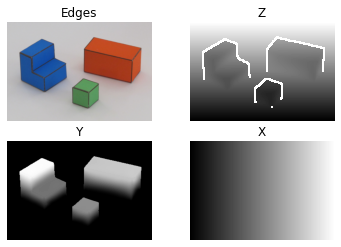

In [274]:
E = occlusion_edges.astype(np.float32);
E[E > 0] = np.nan;
Z = Z+E; #  remove occluded edges

plt.figure()
plt.subplot(2,2,1)
plt.imshow(img[1:-1, 1:-1].astype(np.uint8))
plt.axis('off')
plt.title('Edges')

plt.subplot(2,2,2)
plt.imshow(Z[1:-1, 1:-1], cmap='gray')
plt.axis('off')
plt.title('Z')


plt.subplot(2,2,3)
plt.imshow(Y[1:-1, 1:-1], cmap='gray')
plt.axis('off')
plt.title('Y')

plt.subplot(2,2,4)
plt.imshow(X[1:-1, 1:-1], cmap='gray')
plt.axis('off')
plt.title('X')

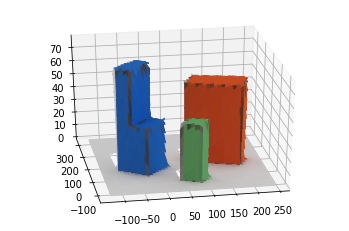

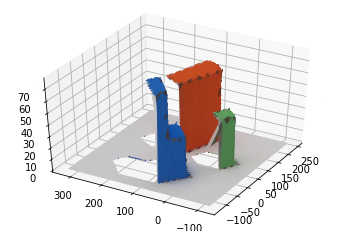

In [275]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Specify here the angle you want to see
ax.view_init(30, -100)
ax.plot_surface(X,Z,Y, facecolors=img/255., shade=False)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Specify here the angle you want to see
ax.view_init(40, -150)
ax.plot_surface(X,Z,Y, facecolors=img/255., shade=False)